# Travel Insurance
Created By: Sean Kristian Anderson
***

### Business Problem Understanding
***

##### **Background**

Travel insurance is an insurance product for covering any losses while traveling, such as flight delay, loss luggage, trip cancellation, and more. Travel insurance companies offer various plans based on type of losses that can be claimed. In this problem, a travel insurance company aims to predict whether a policyholder will file a claim. This insight helps the company focus on groups less likely to file claims, thereby maximizing profits.

Target feature:     
0&emsp;:&ensp;Won't submit an insurance claim       
1&emsp;&nbsp;:&ensp;Will submit an insurance claim

##### **Problem Statement**

There are some accidents that couldn't be predicted whether a complain will be filed or not, such as:
- Delayed / canceled flight due to bad weather,
- Lost item due to pickpocket,
- Illness due to extreme weather in destination country,
- etc.

##### **Goals**

Based on the problem statement, this company aims to predict whether policyholder will file a claim or not. By focusing on group that won't likely to file a claim to increase its company profit.

##### **Metric Evaluation**

Type I Error (FP)   
Consequence: People predicted as will file a claim, but they actually won't file a claim. This will mess up the company budgeting.      
Type II Error (FN)      
Consequence: People predicted as won't file a claim, but they will actually file a claim. This will reduce company benefit.

Based on each consequences, the main model aim is to avoid Type II Error (FN) as much as possible while focus on increasing the true negative score. As the company should focus targeting these group of people, since they won't file a claim and could maximize the profit.

### Data Understanding
***

##### **Import libraries**

In [2]:
# Library
import pandas as pd
import numpy as np
import pickle

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler, KBinsDiscretizer, FunctionTransformer, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.decomposition import PCA

# Model Selection
from sklearn import metrics
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score, RandomizedSearchCV

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.ensemble import BalancedRandomForestClassifier

# GCP
import os
from google.cloud import bigquery, storage, aiplatform

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

##### **Import dataset**

In [3]:
df = pd.read_csv('./data_travel_insurance.csv')

display(df.head(), df.tail())

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
0,C2B,Airlines,Online,Annual Silver Plan,F,365,SINGAPORE,216.0,54.0,57,No
1,EPX,Travel Agency,Online,Cancellation Plan,NaN,4,MALAYSIA,10.0,0.0,33,No
2,JZI,Airlines,Online,Basic Plan,M,19,INDIA,22.0,7.7,26,No
3,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,20,UNITED STATES,112.0,0.0,59,No
4,C2B,Airlines,Online,Bronze Plan,M,8,SINGAPORE,16.0,4.0,28,No


,Agency,Agency Type,Distribution Channel,Product Name,Gender,Duration,Destination,Net Sales,Commision (in value),Age,Claim
44323,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,14,CHINA,30.0,0.00,36,Yes
44324,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,17,AUSTRALIA,79.2,47.52,47,No
44325,TST,Travel Agency,Offline,Travel Cruise Protect,M,64,THAILAND,30.0,10.50,50,No
44326,EPX,Travel Agency,Online,2 way Comprehensive Plan,NaN,51,CHINA,36.0,0.00,36,No
44327,CWT,Travel Agency,Online,Rental Vehicle Excess Insurance,NaN,172,SINGAPORE,0.0,17.82,31,No


##### **Dataset Information**

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| Agency | Text | Name of agency |
| Agency Type | Text | Type of travel insurance agencies |
| Distribution Channel | Text | Channel of travel insurance agencies |
| Product Name | Text | Name of travel insurance products |
| Gender | Text | Gender of insured |
| Duration | Integer | Duration of travel |
| Destination | Text | Destination of travel |
| Net Sales | Float | Amount of travel insurance policies |
| Commission (in value) | Float | Commission received for travel insurance agency |
| Age | Integer | Age of insured |
| Claim | Text | Claim status |

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44328 entries, 0 to 44327
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Agency                44328 non-null  object 
 1   Agency Type           44328 non-null  object 
 2   Distribution Channel  44328 non-null  object 
 3   Product Name          44328 non-null  object 
 4   Gender                12681 non-null  object 
 5   Duration              44328 non-null  int64  
 6   Destination           44328 non-null  object 
 7   Net Sales             44328 non-null  float64
 8   Commision (in value)  44328 non-null  float64
 9   Age                   44328 non-null  int64  
 10  Claim                 44328 non-null  object 
dtypes: float64(2), int64(2), object(7)
memory usage: 3.7+ MB


### Data Cleaning
***

In [ ]:
cleaned_df = df.copy()

display(cleaned_df.describe(include='object'), cleaned_df.describe(include='number'))

,Agency,Agency Type,Distribution Channel,Product Name,Gender,Destination,Claim
count,44328,44328,44328,44328,12681,44328,44328
unique,16,2,2,26,2,138,2
top,EPX,Travel Agency,Online,Cancellation Plan,M,SINGAPORE,No
freq,24656,32113,43572,12979,6504,9267,43651


,Duration,Net Sales,Commision (in value),Age
count,44328.000000,44328.000000,44328.000000,44328.000000
mean,49.424292,40.550948,9.707692,39.925600
std,109.153961,48.661970,19.625637,13.954926
min,-1.000000,-357.500000,0.000000,0.000000
25%,9.000000,18.000000,0.000000,35.000000
50%,22.000000,26.500000,0.000000,36.000000
75%,53.000000,48.000000,11.550000,43.000000
max,4881.000000,810.000000,283.500000,118.000000


##### **Duplicate Values**

In [ ]:
df_shape = df.shape
duplicated_values_count = cleaned_df.duplicated().sum()

print(f"Original cleaned df shape: { df_shape }")
print(f"Duplicated values count:  { duplicated_values_count }")
print(f"Percentage of duplicated values: { duplicated_values_count / df_shape[0] * 100 }%")

Original cleaned df shape: (44328, 11)
Duplicated values count:  4667
Percentage of duplicated values: 10.528334235697526%


In [ ]:
'''
Even though the duplicated value counts seems big, these data only represents 10% of the original data.
So it is better to drop whole duplicated values than to disrupt the ML accuracy.
'''

cleaned_df.drop_duplicates(inplace=True)

print(f"Cleaned data shape after removing duplicates: {cleaned_df.shape}")

Cleaned data shape after removing duplicates: (39661, 11)


##### **Missing Values**

In [ ]:
missingVal = cleaned_df.isna().sum()
missingVal[missingVal > 0]

Gender    27667
dtype: int64

In [ ]:
print(f"Percentage of missing values: { cleaned_df['Gender'].isna().sum() / cleaned_df.shape[0] * 100}%")

Percentage of missing values: 69.75870502508762%


In [ ]:
'''
Given the high percentage of missing values in Gender column, it is reasonable to drop this column entirely.
In the context of travel claims, it is assumed that gender is unlikely to influence whether a claim is filed, as travel losses are typically caused by external factors such as natural disaster, or other.
'''

cleaned_df.drop(columns='Gender', axis=1, inplace=True)

##### **Numerical Outliers**

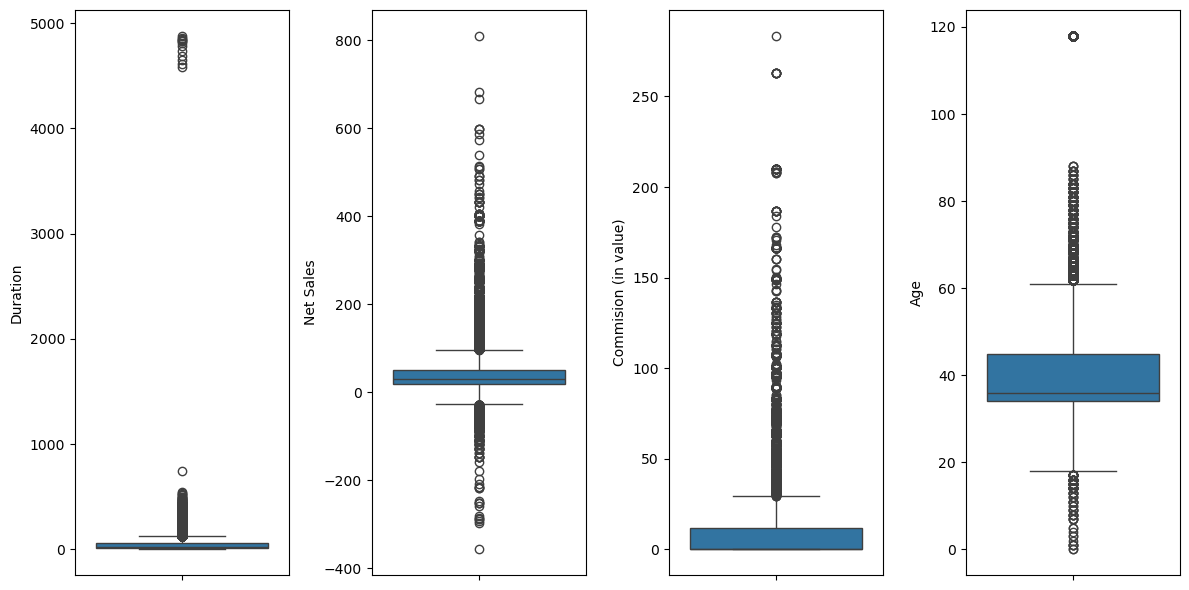

In [ ]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=cleaned_df[column])
plt.tight_layout()
plt.show()

In [ ]:
'''
Remove global / extreme outliers in numerical columns
'''

original_cleaned_df_shape = cleaned_df.shape

cleaned_df = cleaned_df[(cleaned_df['Duration'] > 0) & (cleaned_df['Duration'] < 600) & 
                        (cleaned_df['Net Sales'] >= 0) & (cleaned_df['Net Sales'] <= 600) &
                        (cleaned_df['Age'] > 0) & (cleaned_df['Age'] < 100)]

print(f"Original cleaned df shape: { original_cleaned_df_shape }")
print(f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }")
print(f"Cleaned df shape after removing outliers using IQR method: { cleaned_df.shape }",)
print(f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

Original cleaned df shape: (39661, 10)
Number of removed values:  993
Cleaned df shape after removing outliers using IQR method: (38668, 10)
Percentage of removed values: 2.5037190186833413%


In [ ]:
'''
Iteratively removing outliers
'''

original_cleaned_df_shape = cleaned_df.shape

cleaned_df = cleaned_df[(cleaned_df['Duration'] < 500) & (cleaned_df['Net Sales'] <= 400) & (cleaned_df['Age'] < 80)]

print(f"Original cleaned df shape: { original_cleaned_df_shape }")
print(f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }")
print(f"Cleaned df shape after removing outliers using IQR method: { cleaned_df.shape }",)
print(f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

Original cleaned df shape: (38668, 10)
Number of removed values:  124
Cleaned df shape after removing outliers using IQR method: (38544, 10)
Percentage of removed values: 0.3206785972897486%


In [ ]:
'''
Removing the rest of outliers using IQR method
'''

def count_outliers(data):
    data = np.array(data)
    
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    return {'lower_bound': lower_bound, 'upper_bound': upper_bound}

original_cleaned_df_shape = cleaned_df.shape

age_outliers = count_outliers(cleaned_df['Age'])
cleaned_df = cleaned_df[(cleaned_df['Age'] >= age_outliers['lower_bound']) & 
                        (cleaned_df['Age'] <= age_outliers['upper_bound'])]

duration_outliers = count_outliers(cleaned_df['Duration'])
cleaned_df = cleaned_df[(cleaned_df['Duration'] >= duration_outliers['lower_bound']) & 
                        (cleaned_df['Duration'] <= duration_outliers['upper_bound'])]

net_sales_outliers = count_outliers(cleaned_df['Net Sales'])
cleaned_df = cleaned_df[(cleaned_df['Net Sales'] >= net_sales_outliers['lower_bound']) & 
                        (cleaned_df['Net Sales'] <= net_sales_outliers['upper_bound'])]

print(f"Original cleaned df shape: { original_cleaned_df_shape }")
print(f"Number of removed values:  { original_cleaned_df_shape[0] - cleaned_df.shape[0] }")
print(f"Cleaned df shape after removing outliers using IQR method: { cleaned_df.shape }",)
print(f"Percentage of removed values: { ( original_cleaned_df_shape[0] - cleaned_df.shape[0] ) / original_cleaned_df_shape[0] * 100 }%")

Original cleaned df shape: (38544, 10)
Number of removed values:  7377
Cleaned df shape after removing outliers using IQR method: (31167, 10)
Percentage of removed values: 19.139165628891654%


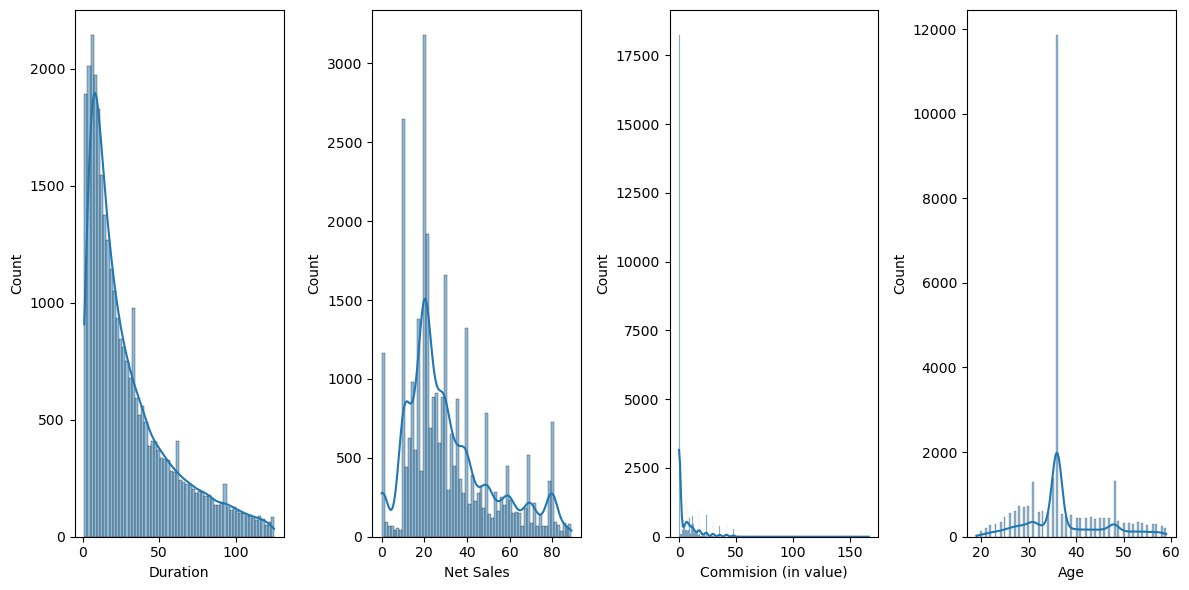

In [ ]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.histplot(data=cleaned_df[column], kde=True)
plt.tight_layout()
plt.show()

##### **Categorical Outliers**

<function matplotlib.pyplot.show(close=None, block=None)>

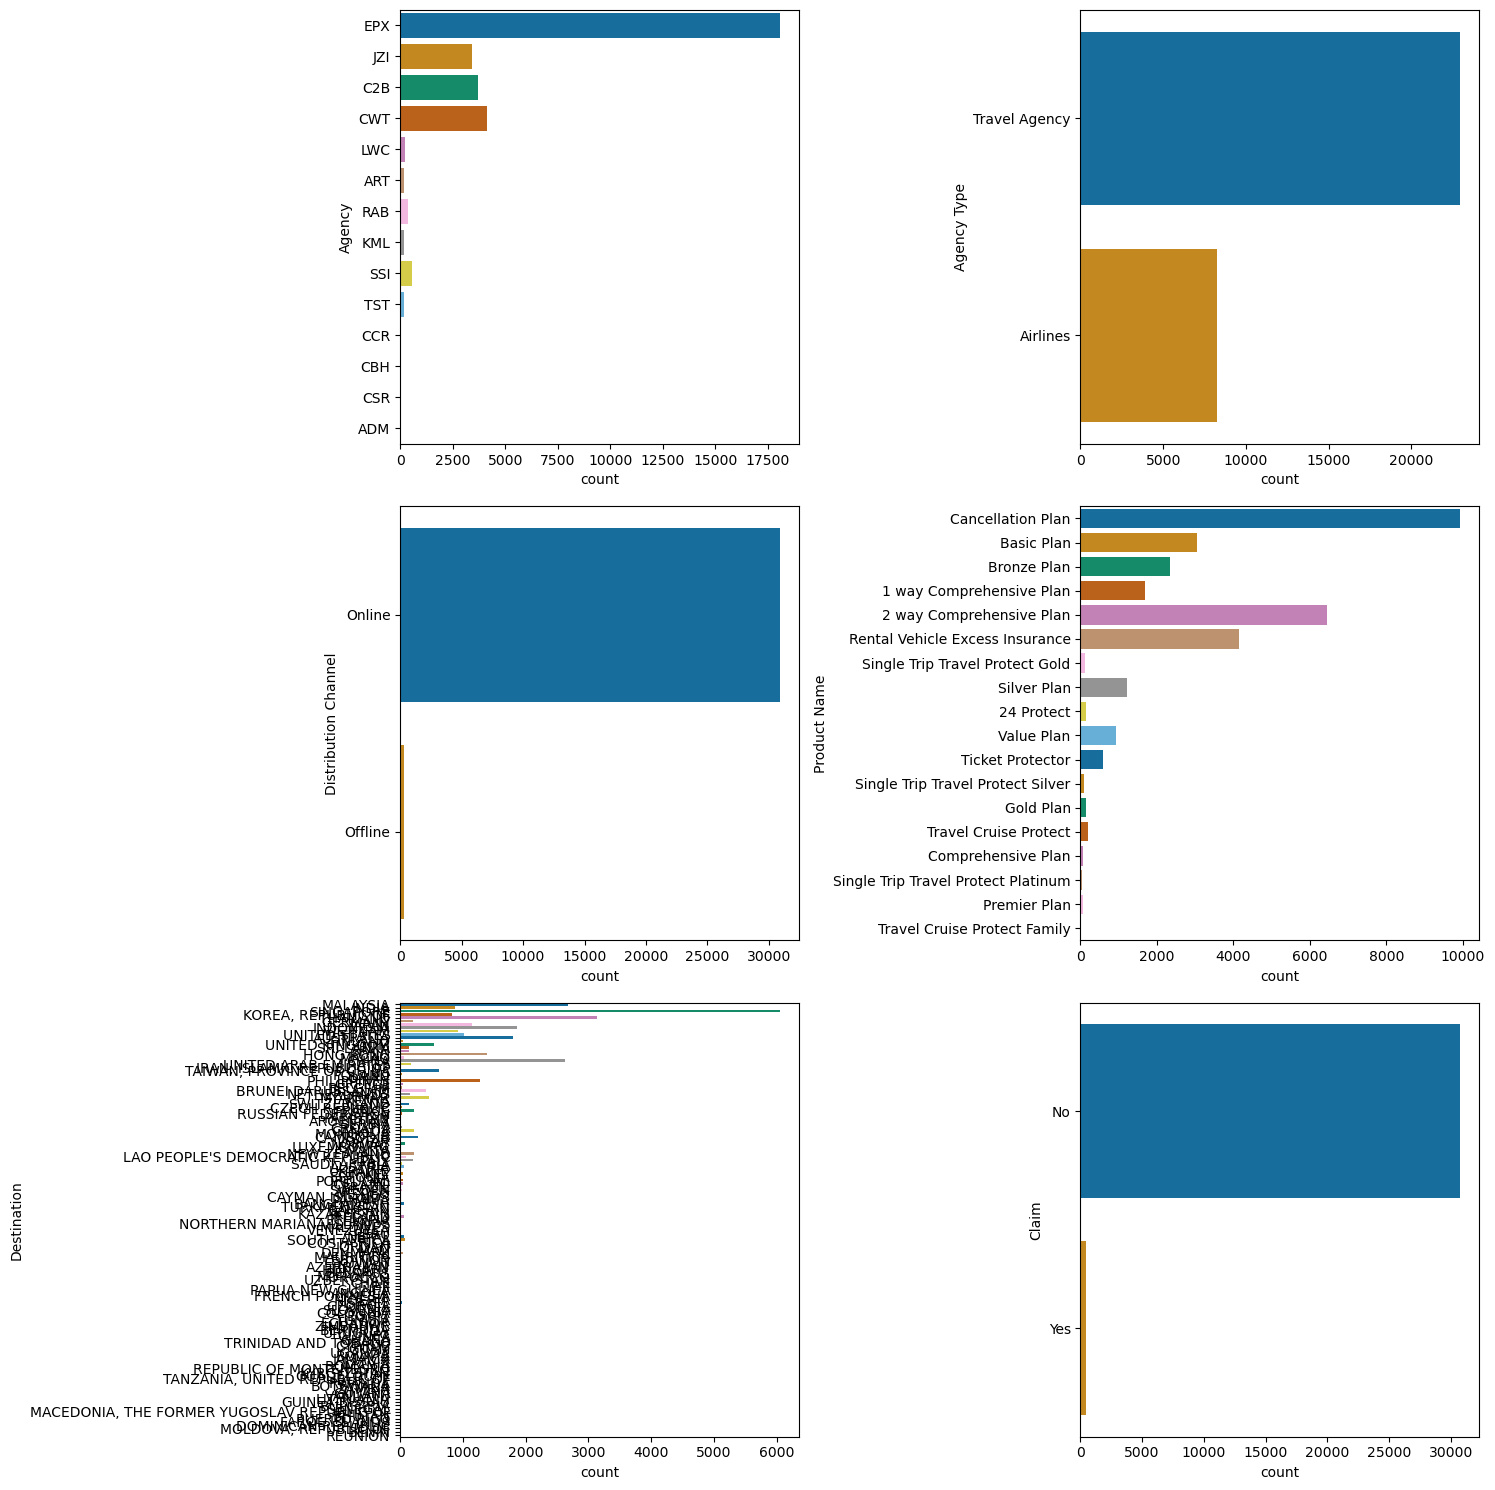

In [ ]:
plt.figure(figsize=(15, 15))
for i, column in enumerate(cleaned_df.describe(include='object'), 1):
    plt.subplot(3, 2, i)
    sns.countplot(data=cleaned_df[column], palette='colorblind')
plt.tight_layout()
plt.show

In [ ]:
display(cleaned_df.describe(include='object'), cleaned_df.describe(include='number'))

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Claim
count,31167,31167,31167,31167,31167,31167
unique,14,2,2,18,131,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,No
freq,18049,22923,30864,9918,6046,30745


,Duration,Net Sales,Commision (in value),Age
count,31167.000000,31167.000000,31167.000000,31167.000000
mean,30.152276,31.269843,6.208976,37.346264
std,27.748025,20.212131,10.648232,8.005074
min,1.000000,0.000000,0.000000,19.000000
25%,9.000000,18.000000,0.000000,34.000000
50%,20.000000,26.000000,0.000000,36.000000
75%,42.000000,40.000000,9.100000,40.000000
max,125.000000,89.000000,166.320000,59.000000


### Feature Engineering
***

##### **Categorical Columns**

In [ ]:
cleaned_df.describe(include='object')

,Agency,Agency Type,Distribution Channel,Product Name,Destination,Claim
count,31167,31167,31167,31167,31167,31167
unique,14,2,2,18,131,2
top,EPX,Travel Agency,Online,Cancellation Plan,SINGAPORE,No
freq,18049,22923,30864,9918,6046,30745


In [ ]:
for column in cleaned_df.describe(include='object'):
    display(cleaned_df[column].value_counts().head())

Agency
EPX    18049
CWT     4153
C2B     3690
JZI     3429
SSI      579
Name: count, dtype: int64

Agency Type
Travel Agency    22923
Airlines          8244
Name: count, dtype: int64

Distribution Channel
Online     30864
Offline      303
Name: count, dtype: int64

Product Name
Cancellation Plan                  9918
2 way Comprehensive Plan           6433
Rental Vehicle Excess Insurance    4153
Basic Plan                         3042
Bronze Plan                        2343
Name: count, dtype: int64

Destination
SINGAPORE    6046
THAILAND     3143
MALAYSIA     2679
CHINA        2634
INDONESIA    1862
Name: count, dtype: int64

Claim
No     30745
Yes      422
Name: count, dtype: int64

In [ ]:
'''
One hot encoding: Agency Type, Distribution Channel
Label encoding: Claim
Binary: Agency, Product Name, Destination

Ordinal encoding not used for any columns because there are no sequence
'''

categorical_transformer = [
    ('onehot', OneHotEncoder(drop='first'), ['Agency Type', 'Distribution Channel']),
    ('binary', ce.BinaryEncoder(), ['Agency', 'Product Name', 'Destination']),
]

##### **Numerical Columns**

In [ ]:
cleaned_df.describe(include='number')

,Duration,Net Sales,Commision (in value),Age
count,31167.000000,31167.000000,31167.000000,31167.000000
mean,30.152276,31.269843,6.208976,37.346264
std,27.748025,20.212131,10.648232,8.005074
min,1.000000,0.000000,0.000000,19.000000
25%,9.000000,18.000000,0.000000,34.000000
50%,20.000000,26.000000,0.000000,36.000000
75%,42.000000,40.000000,9.100000,40.000000
max,125.000000,89.000000,166.320000,59.000000


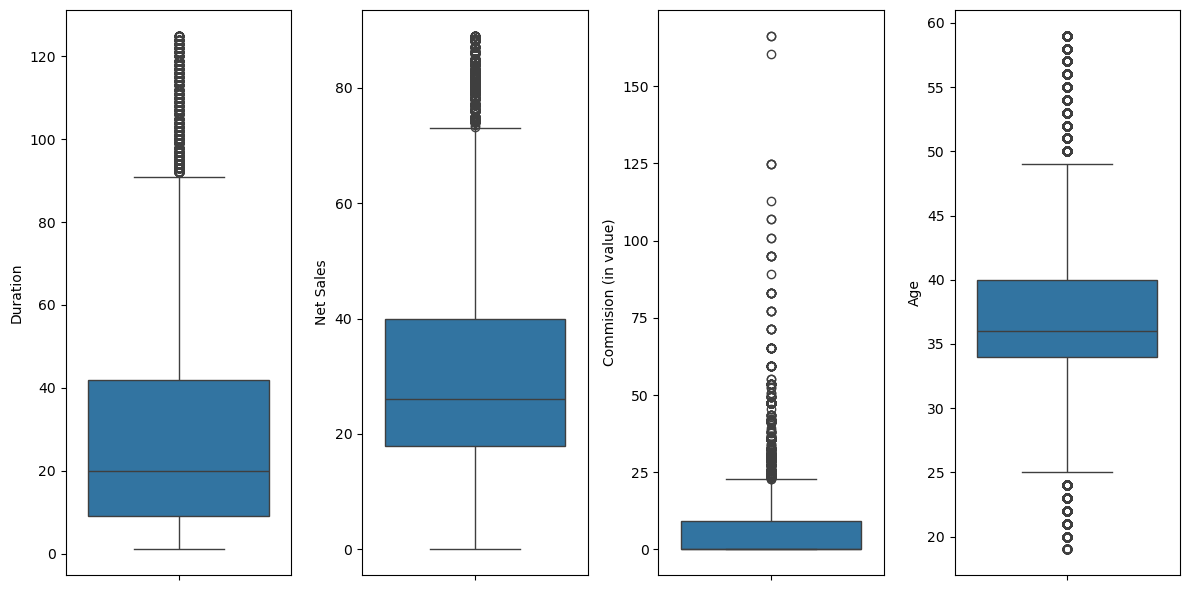

In [ ]:
plt.figure(figsize=(12, 6))
for i, column in enumerate(cleaned_df.describe(include='number'), 1):
    plt.subplot(1, 4, i)
    sns.boxplot(data=cleaned_df[column])
plt.tight_layout()
plt.show()

In [ ]:
'''
Binning: Commission
-> Extremely skewed. Many zero values shown by Q1 and Q3

Robust Scaler: Net sales, Duration, Age
-> Because these columns have big amount of outliers
'''

def commission_binning(X):
    return (X > 0).astype(int)

numerical_transformer = [
    ('robust', RobustScaler(), ['Net Sales', 'Duration', 'Age']),
    ('binning', FunctionTransformer(commission_binning), ['Commision (in value)']),
]

##### **Data Split**

In [ ]:
X = cleaned_df.drop(columns=['Claim'])
y = cleaned_df['Claim']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [ ]:
feature_engineering_transformer = ColumnTransformer(
    numerical_transformer + categorical_transformer,
    remainder='passthrough'
)

X_train_prep = feature_engineering_transformer.fit_transform(X_train)
X_test_prep = feature_engineering_transformer.transform(X_test)

In [ ]:
columns_name = []

for i in range(4):
    if i == 1:
        columns_name += ['Commision (in value)']
        continue
    
    columns_name += list(feature_engineering_transformer.transformers_[i][1].get_feature_names_out())

X_train_prep = pd.DataFrame(X_train_prep)
X_test_prep = pd.DataFrame(X_test_prep)

X_train_prep.columns = columns_name
X_test_prep.columns = columns_name

In [ ]:
X_train_prep.head()

,Net Sales,Duration,Age,Commision (in value),Agency Type_Travel Agency,Distribution Channel_Online,Agency_0,Agency_1,Agency_2,Agency_3,Product Name_0,Product Name_1,Product Name_2,Product Name_3,Product Name_4,Destination_0,Destination_1,Destination_2,Destination_3,Destination_4,Destination_5,Destination_6
0,-0.363636,-0.424242,-0.833333,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.168182,1.454545,-0.833333,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.386364,0.151515,-1.000000,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
3,1.068182,0.939394,-0.500000,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.968182,0.666667,-0.333333,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


##### **PCA**

In [ ]:
X_train_prep.shape

(21816, 22)

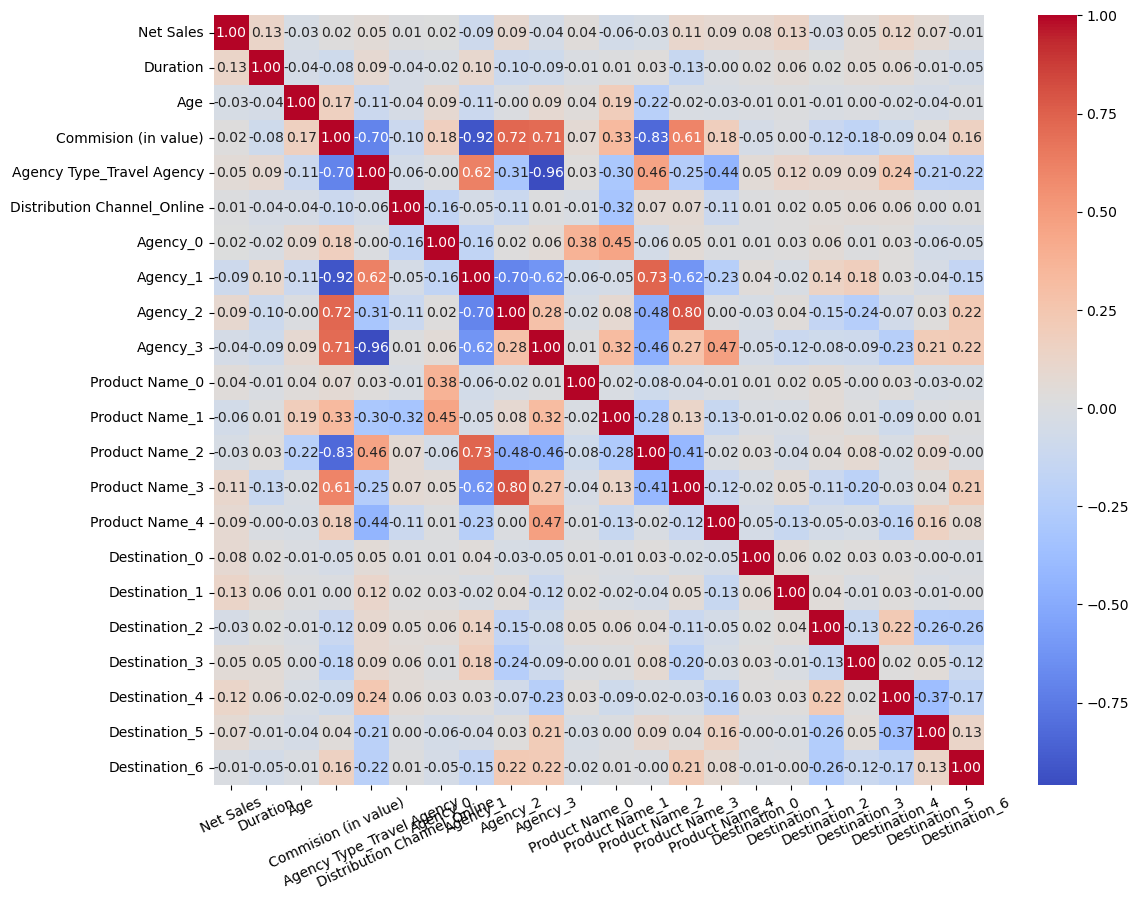

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(X_train_prep.select_dtypes(include=np.number).corr(), cmap='coolwarm', annot=True, fmt=".2f", square=True)
plt.xticks(rotation=25)
plt.show()

From the correlation heatmap shown above, shown that PCA shouldn't be done on this dataset.     
Even though there are some high correlation shown by some features, but most of the features has low correlation.
And there is shown that one feature has 0 correlation (ex. Destination_5 and Net Sales)

### Modeling
***

##### **Model Benchmark to Train Data**

In [ ]:
algorithm_list = [LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(), XGBClassifier()]

algorithm_list_name = ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGB']

In [ ]:
score_list_recall = []
mean_list_recall = []
std_list_recall = []

score_list_roc_auc = []
mean_list_roc_auc = []
std_list_roc_auc = []

for algorithm in algorithm_list:
    cv_score_recall = cross_val_score(
        estimator = algorithm,
        X = X_train_prep,
        y = y_train,
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='recall'
    )
    
    cv_score_roc = cross_val_score(
        estimator = algorithm,
        X = X_train_prep,
        y = y_train,
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring='roc_auc'
    )
    
    score_list_recall.append(cv_score_recall)
    mean_list_recall.append(cv_score_recall.mean())
    std_list_recall.append(cv_score_recall.std())
    
    score_list_roc_auc.append(cv_score_roc)
    mean_list_roc_auc.append(cv_score_roc.mean())
    std_list_roc_auc.append(cv_score_roc.std())

In [ ]:
'''
TP : Actual 1, Predicted 1
FP : Actual 0, Predicted 1 ( Type I Error )
TN : Actual 0, Predicted 0
FN : Actual 1, Predicted 0 ( Type II Error )

Recall is used because the company goal is to maximize its profit by focusing on groups that less likely file a claim.
Means to minimize the FN (False Negative)
'''

cv_score_df = pd.DataFrame()
cv_score_df['Model'] = algorithm_list_name
cv_score_df['Mean Recall'] = mean_list_recall
cv_score_df['Std Recall'] = std_list_recall
cv_score_df['Mean ROC AUC'] = mean_list_roc_auc
cv_score_df['Std ROC AUC'] = std_list_roc_auc

cv_score_df = cv_score_df.set_index('Model')
cv_score_df.sort_values(by='Mean ROC AUC', ascending=False)

,Mean Recall,Std Recall,Mean ROC AUC,Std ROC AUC
Model,,,,
Logistic Regression,0.000000,0.000000,0.811441,0.021015
XGB,0.000000,0.000000,0.759052,0.026684
Random Forest,0.006780,0.008303,0.686575,0.022611
KNN,0.006780,0.008303,0.575051,0.013828
Decision Tree,0.037288,0.006780,0.510017,0.003528


Logistic Regression has the highest ROC AUC score meaning that it is the best algorithms so far even when the recall value is 0.       
For now, let's assume the recall value is 0 is caused by imbalanced dataset.      

##### **Model Benchmark to Test Data**

In [ ]:
fpr_score_list = []
tpr_score_list = []
auc_score_list = []
cm_list = []

for algorithm in algorithm_list:
    clf = algorithm.fit(X_train_prep, y_train)
    y_pred = clf.predict(X_test_prep)
    y_pred_proba = clf.predict_proba(X_test_prep)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    fpr_score_list.append(fpr)
    tpr_score_list.append(tpr)
    auc_score_list.append(auc)
    cm_list.append(cm)

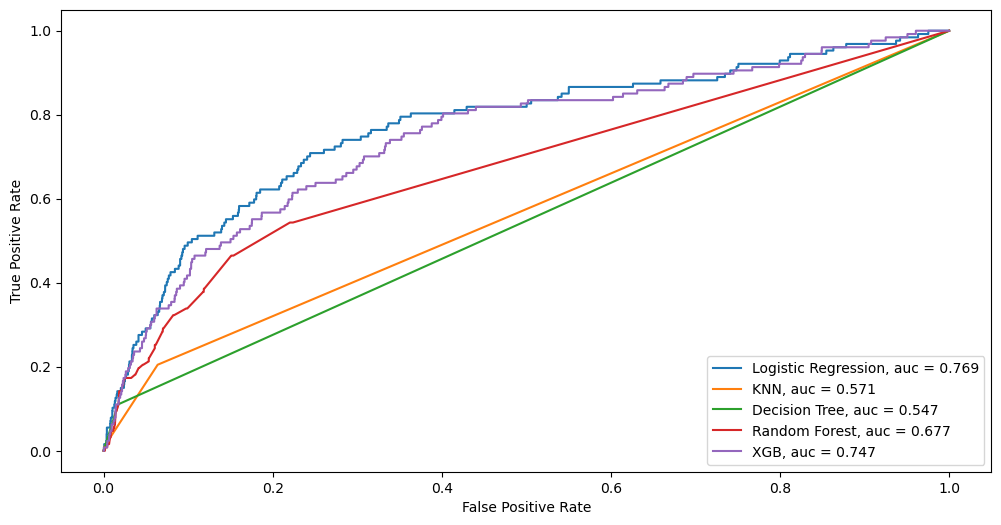

In [ ]:
plt.figure(figsize=(12, 6))

for index in range(len(algorithm_list)):
    plt.plot(fpr_score_list[index], tpr_score_list[index], label=f"{algorithm_list_name[index]}, auc = {auc_score_list[index]:.3f}")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

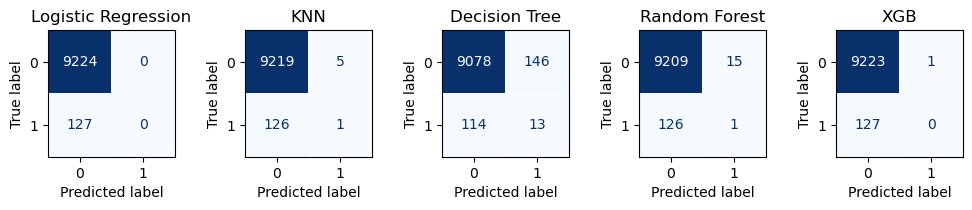

In [ ]:
fig, axes = plt.subplots(1, len(cm_list), figsize=(len(cm_list) * 2, 2))

for i, (cm, ax) in enumerate(zip(cm_list, axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(algorithm_list_name[i])

plt.tight_layout()
plt.show()

Again, Logistic Regression shows the highest ROC AUC score in the data test.        
And from the confusion matrix above, Logistic Regression has the smallest number of total error (FP and FN)

##### **Oversampling**

**SMOTE**

In [ ]:
y_value_counts = np.unique(y, return_counts=True)

y_value_counts_df = pd.DataFrame()
y_value_counts_df["Target"] = y_value_counts[0]
y_value_counts_df["Count"] = y_value_counts[1]
y_value_counts_df["Percentage"] = [(y_value_counts[1][0]/len(y) * 100), (y_value_counts[1][1]/len(y) * 100)]

y_value_counts_df.set_index('Target')

,Count,Percentage
Target,,
0,30745,98.646004
1,422,1.353996


In [ ]:
sm = SMOTE(sampling_strategy='auto', random_state=42)

X_train_smote, y_train_smote = sm.fit_resample(X_train_prep, y_train)

In [ ]:
y_smote_value_counts = np.unique(y_train_smote, return_counts=True)

y_smote_value_counts_df = pd.DataFrame()
y_smote_value_counts_df["Target"] = y_smote_value_counts[0]
y_smote_value_counts_df["Count"] = y_smote_value_counts[1]
y_smote_value_counts_df["Percentage"] = (y_smote_value_counts[1] / len(y_train_smote) * 100)

y_smote_value_counts_df.set_index('Target')

,Count,Percentage
Target,,
0,21521,50.0
1,21521,50.0


### Evaluation
***

In [ ]:
def model_metrics(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    y_train_proba = model.predict_proba(X_train)[:, 1] if hasattr(model, "predict_proba") else None
    y_test_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    train_roc_auc = roc_auc_score(y_train, y_train_proba) if y_train_proba is not None else "N/A"
    test_roc_auc = roc_auc_score(y_test, y_test_proba) if y_test_proba is not None else "N/A"
    
    train_f1 = f1_score(y_train, y_train_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    
    train_recall = recall_score(y_train, y_train_pred)
    test_recall = recall_score(y_test, y_test_pred)
    
    train_precision = precision_score(y_train, y_train_pred)
    test_precision = precision_score(y_test, y_test_pred)
    
    train_cm = confusion_matrix(y_train, y_train_pred)
    test_cm = confusion_matrix(y_test, y_test_pred)
    
    result_df = pd.DataFrame()
    result_df['Metric'] = ['Accuracy', 'ROC AUC', 'F1 Score', 'Recall', 'Precission']
    result_df['Train'] = [f"{train_accuracy:<20.4f}", f"{train_roc_auc:<20.4f}", f"{train_f1:<20.4f}", f"{train_recall:<20.4f}", f"{train_precision:<20.4f}"]
    result_df['Test'] = [f"{test_accuracy:<20.4f}", f"{test_roc_auc:<20.4f}", f"{test_f1:<20.4f}", f"{test_recall:<20.4f}", f"{test_precision:<20.4f}"]
    result_df = result_df.set_index('Metric')
    
    return {"metrics": result_df, "train_cm": train_cm, "test_cm": test_cm}

##### **Evaluation Metrics without Oversampling**

In [ ]:
lr = LogisticRegression()

lr_default = lr.fit(X_train_prep, y_train)

result = model_metrics(lr_default, X_train_prep, y_train, X_test_prep, y_test)

result['metrics']

,Train,Test
Metric,,
Accuracy,0.9865,0.9864
ROC AUC,0.8256,0.7694
F1 Score,0.0000,0.0000
Recall,0.0000,0.0000
Precission,0.0000,0.0000


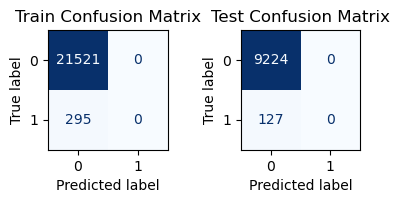

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 2, 2))

for i, (cm, ax) in enumerate(zip([result['train_cm'], result['test_cm']], axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(["Train Confusion Matrix", "Test Confusion Matrix"][i])

plt.tight_layout()
plt.show()

##### **Evaluation Metrics with Oversampling**

In [ ]:
lr = LogisticRegression()

lr_oversampling = lr.fit(X_train_smote, y_train_smote)

result_oversampling = model_metrics(lr_oversampling, X_train_prep, y_train, X_test_prep, y_test)

result_oversampling['metrics']

,Train,Test
Metric,,
Accuracy,0.7997,0.7857
ROC AUC,0.8261,0.7631
F1 Score,0.0892,0.0748
Recall,0.7254,0.6378
Precission,0.0475,0.0397


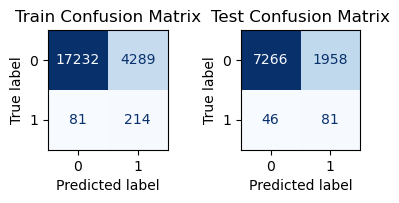

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(2 * 2, 2))

for i, (cm, ax) in enumerate(zip([result_oversampling['train_cm'], result_oversampling['test_cm']], axes), 0):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)
    ax.set_title(["Train Confusion Matrix", "Test Confusion Matrix"][i])

plt.tight_layout()
plt.show()

From the comparison between original and oversampled data shown that the evaluation metrics on original data is better.     
But from the confusion matrix, it is shown that the oversampled data performs better in decreasing the FN prediction, which is the goal of the company.

##### **Hyperparameter Tuning**

In [ ]:
lr = LogisticRegression()

param_grid = {
    'penalty': ['l2', 'elasticnet'], 
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200],
    'tol': [1e-4, 1e-3],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True],
    'intercept_scaling': [1],
    'multi_class': ['ovr'],
    'l1_ratio': [None, 0.5],
    'warm_start': [False],
    'random_state': [42],
}

grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='recall', cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42))

grid_search.fit(X_train_smote, y_train_smote)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters: {best_params}")

Best parameters: {'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'ovr', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'tol': 0.001, 'warm_start': False}


In [ ]:
default_model = lr.fit(X_train_smote, y_train_smote)
y_pred_default = default_model.predict(X_test_prep)
y_pred_proba_default = default_model.predict_proba(X_test_prep)

y_pred_tuned = best_model.predict(X_test_prep)
y_pred_proba_tuned = best_model.predict_proba(X_test_prep)

print("\nClassification Report before Hyperparameter Tuning:\n")
print(classification_report(y_test, y_pred_default))

print("Classification Report after Hyperparameter Tuning:\n")
print(classification_report(y_test, y_pred_tuned))


Classification Report before Hyperparameter Tuning:

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      9224
           1       0.04      0.64      0.07       127

    accuracy                           0.79      9351
   macro avg       0.52      0.71      0.48      9351
weighted avg       0.98      0.79      0.87      9351

Classification Report after Hyperparameter Tuning:

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      9224
           1       0.04      0.64      0.07       127

    accuracy                           0.79      9351
   macro avg       0.52      0.71      0.48      9351
weighted avg       0.98      0.79      0.87      9351



In [ ]:
print("ROC AUC Score before Hyperparameter Tuning:")
print(roc_auc_score(y_test, y_pred_default))

print("\nROC AUC Score after Hyperparameter Tuning:")
print(roc_auc_score(y_test, y_pred_tuned))

ROC AUC Score before Hyperparameter Tuning:
0.7127614712731594

ROC AUC Score after Hyperparameter Tuning:
0.7128698841092391


From the classification report and the ROC AUC comparison score above, it is seen that are no differences in the classification report between default parameter and tuned parameter. 

### Conclusion & Recommendation
***

##### **Feature Importance**

In [ ]:
coefficients = best_model.coef_[0]
feature_names = X_train_smote.columns

importance = np.abs(coefficients)

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

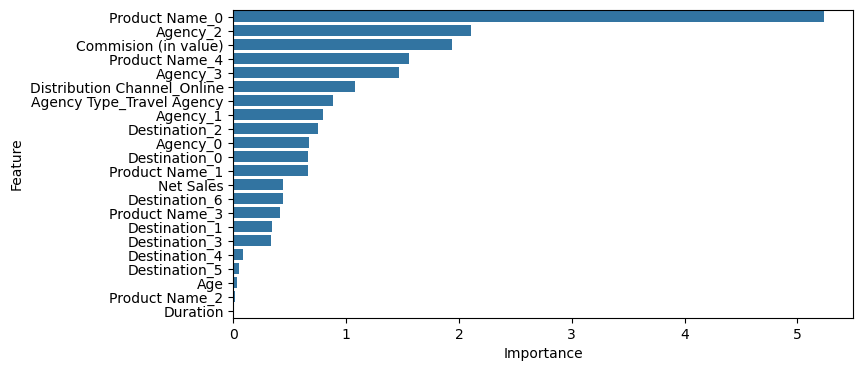

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.show()

For this Logistic Regression model, the most important feature is `Product Name_0` as it shown on the barplot above. And there is a big gap between this feature with the between this feature with the second most important feature which is `Agency`

##### **Conclusion**

In [ ]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      9224
           1       0.04      0.64      0.07       127

    accuracy                           0.79      9351
   macro avg       0.52      0.71      0.48      9351
weighted avg       0.98      0.79      0.87      9351



From the classification report above, this model is able to predict 79% of people who will not file claim, and 21% of people mispredicted as will file a claim.        
Also, this model is able to predict 64% of people who will file a claim, and 36% of people mispredicted as will not file a claim.

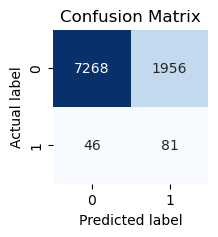

In [ ]:
cm = confusion_matrix(y_test, y_pred_tuned)

plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("Actual label")
plt.show()

From the confusion matrix shown above, it seen that the FN value is pretty low only 46 value. Which is the company's main goal.         
FP value is pretty high with 1956 value as the trade-off to reduce the FN, which is acceptable since the impact in financial for FP is less severe than the FN.     
In addition, this model predicts very well on TP with 7268 value.

Let's assume the cost for customer to subscribe the insurance is around 200 USD, and they can claim this insurance for maximum 10.000 USD.      
Based on this this assumption, the impact for this machine learning can be counted as:      
FN Cost&emsp;&emsp;&emsp;: 10.000 x 46&emsp;= **460.000 USD**       
TP Benefit&emsp;&emsp;: 200 x 7.268&emsp;= **1.453.600 USD**

From this calculation, the company will gain **993.600 USD**

Moreover, this model predicts well on the TN with 81 value. So the company could prepare around **81.000** USD beforehand in case people filing a claim for the maximum value.

#### **Recommendation**

There are several things can be done to improve the model even better, such as:
- Apply different oversampling methods since the data is extremely imbalanced,
- Handle data better with highly erratic graphs,
- Add another features such as date since claim status might be vary depends on weather, holidays, etc. 

### Export model
***

In [ ]:
def commission_binning(X):
    return (X > 0).astype(int)

feature_engineering_transformer = ColumnTransformer(
    [
        ("robust", RobustScaler(), ["Net Sales", "Duration", "Age"]),
        ("onehot", OneHotEncoder(drop="first"), ["Agency Type", "Distribution Channel"]),
        ('binning', FunctionTransformer(commission_binning), ['Commision (in value)']),
        ("binary", ce.BinaryEncoder(), ["Agency", "Product Name", "Destination"]),
    ],
    remainder="passthrough",
)

X_train_transformed = feature_engineering_transformer.fit_transform(X_train)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

best_model.fit(X_train_smote, y_train_smote)

with open("model.pkl", "wb") as file:
    pickle.dump({ 
        "model": best_model,
        "preprocessor": feature_engineering_transformer,
        "y_test": y_test,
        "y_pred": y_pred_tuned
    }, file)

print("Model and preprocessor saved successfully!")


Model and preprocessor saved successfully!


### GCP
***

In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "trial_bigq.json"

project_id = 'dtidsUS'
dataset_id = 'capstone'
table_id = 'data_travel_insurance'
region = 'us-central1'
bucket_name = 'modul4'
blob_name = 'sean/data_travel_insurance.csv'

client = bigquery.Client(project='dtidsus')

In [ ]:
try : 
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.get_bucket(bucket_name)
    data_capstone = bucket.blob('sean/data_travel_insurance.csv')
    data_capstone.upload_from_filename('data_travel_insurance.csv')

    print ("Uploading model succeeded")
except:
    raise TypeError("An exception occurred")

Uploading model succeeded


In [ ]:
try : 
    storage_client = storage.Client(project=project_id)
    bucket = storage_client.get_bucket(bucket_name) 
    blob_model = bucket.blob('sean/model/model.pkl')
    blob_model.upload_from_filename('model.pkl')

    print ("Uploading model succeeded")
except:
    raise TypeError("An exception occurred")

Uploading model succeeded


In [ ]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = "dev_trial.json"

In [ ]:
aiplatform.init(project='dtidsus', location='us-central1')

model = aiplatform.Model.upload(
    display_name='sean_model_001',
    artifact_uri="gs://modul4/sean/model",
    serving_container_image_uri="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-2:latest",
)

model.wait()

Creating Model
Create Model backing LRO: projects/41965541199/locations/us-central1/models/3117428825558876160/operations/2905944807702528000
Model created. Resource name: projects/41965541199/locations/us-central1/models/3117428825558876160@1
To use this Model in another session:
model = aiplatform.Model('projects/41965541199/locations/us-central1/models/3117428825558876160@1')


In [ ]:
endpoint = aiplatform.Endpoint.create(
    display_name="sean-endpoint-001",
    project='dtidsus',
    location='us-central1',
)

Creating Endpoint
Create Endpoint backing LRO: projects/41965541199/locations/us-central1/endpoints/3993506496431259648/operations/8794401320489451520
Endpoint created. Resource name: projects/41965541199/locations/us-central1/endpoints/3993506496431259648
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/41965541199/locations/us-central1/endpoints/3993506496431259648')


In [ ]:
min_replica_count: int = 1
max_replica_count: int = 1

endpoint.deploy(
    model=model,
    deployed_model_display_name='sean_model_001',
    machine_type='e2-standard-2',
    min_replica_count=min_replica_count,
    max_replica_count=max_replica_count,
    sync=True, 
)

Deploying Model projects/41965541199/locations/us-central1/models/3117428825558876160 to Endpoint : projects/41965541199/locations/us-central1/endpoints/3993506496431259648
Deploy Endpoint model backing LRO: projects/41965541199/locations/us-central1/endpoints/3993506496431259648/operations/2903693007888842752


FailedPrecondition: 400 Model server exited unexpectedly. Model server logs can be found at https://console.cloud.google.com/logs/viewer?project=41965541199&resource=aiplatform.googleapis.com%2FDeploymentResourcePool&advancedFilter=resource.type%3D%22aiplatform.googleapis.com%2FDeploymentResourcePool%22%0Aresource.labels.deployment_resource_pool_id%3D%22internal_5468597002604380160%22%0Aresource.labels.location%3D%22us-central1%22. 9: Model server exited unexpectedly. Model server logs can be found at https://console.cloud.google.com/logs/viewer?project=41965541199&resource=aiplatform.googleapis.com%2FDeploymentResourcePool&advancedFilter=resource.type%3D%22aiplatform.googleapis.com%2FDeploymentResourcePool%22%0Aresource.labels.deployment_resource_pool_id%3D%22internal_5468597002604380160%22%0Aresource.labels.location%3D%22us-central1%22.

In [ ]:
# PROJECT_ID = 'dtidsus'
# ENDPOINT_ID = "projects/41965541199/locations/us-central1/endpoints/2975692980645527552"
# REGION = 'us-central1'

# aiplatform.init(project=PROJECT_ID, location=REGION)
# endpoint = aiplatform.Endpoint(ENDPOINT_ID)
# prediction = endpoint.predict(instances=[[50000, 1, 3, 1, 23, 131895, 132154, 129237]])

# print("PREDICTION:", prediction)

PREDICTION: Prediction(predictions=[0.0], deployed_model_id='3756025178971176960', metadata=None, model_version_id='1', model_resource_name='projects/41965541199/locations/us-central1/models/179393018653048832', explanations=None)
